# Missing Data

## Learning Objectives
- Learn how to identify and visualise missing data
 - For numerical, categorical and time-series data
- The different types of missing values
- The appropiate techniques to deal with missing data
 - Dropping data
 - Using the mean (but please don't use the mean)
 - Imputation
- Imputing time series and categorical data

In the Data Cleaning lesson, we observed that entries of our data were missing. This **missing data** problem occurs with almost every dataset. Data can go missing because of a wide range of reasons. Perhaps the most common reason is a 'faulty' data acquisition process (e.g. defective sensors for measuring temperature data, incomplete patient information etc), however some other reasons could include accidental data deletion or human error.

Regardless of how data went missing (well.. not actually regardless - we'll see later on how knowing how data went missing may help our analysis), our job as data scientists is to treat our data based on safe and valid assumptions.

Generally speaking, dealing with and treating missing data follows this pipeline:
- Identify and convert missing values to null values
- Analyse how much data is missing, and the type of missing-ness it is
- Either delete the rows with missing values, or impute the missing values

In this lesson, I will show examples on the two following datasets we will use some datasets that you can download running the following cell:

In [65]:
!wget "https://aicore-files.s3.amazonaws.com/Data-Eng/Beijing_PM.csv" \
      "https://aicore-files.s3.amazonaws.com/Data-Eng/datasets_228_482_diabetes.csv" \
      "https://aicore-files.s3.amazonaws.com/Data-Eng/imports-85.data"

--2023-11-13 17:13:56--  https://aicore-files.s3.amazonaws.com/Data-Eng/Beijing_PM.csv
Resolving aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)... 3.5.28.212, 3.5.6.116, 52.216.36.129, ...
Connecting to aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)|3.5.28.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33861756 (32M) [text/csv]
Saving to: ‘Beijing_PM.csv.3’

Beijing_PM.csv.3    100%[===================>]  32.29M  19.3MB/s    in 1.7s    

2023-11-13 17:13:58 (19.3 MB/s) - ‘Beijing_PM.csv.3’ saved [33861756/33861756]

--2023-11-13 17:13:58--  https://aicore-files.s3.amazonaws.com/Data-Eng/datasets_228_482_diabetes.csv
Reusing existing connection to aicore-files.s3.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/csv]
Saving to: ‘datasets_228_482_diabetes.csv.3’

datasets_228_482_di 100%[===================>]  23.31K  --.-KB/s    in 0s      

2023-11-13 17:13:58 (91.4 MB/s) - ‘datasets_


## Identifying Missing Values
One arbitray dataset could present missing values with a variety of differents 'placeholders' for missing values (even over the span of one column!) Examples of common missing values include: `NA`, `-`, `UNKNOWN` etc. The data dictionary/documentation is the first thing you should look at as it may describe how missing values are stored/formatted in the dataset. We should also perform checks by hand - one way to identify missing values is to return the unique values for a column, and sort them.

In [66]:
import pandas as pd
import numpy as np

# From the data documentatiobn:
names = ["symboling", "normalized-losses", "make", "fuel-type", "aspiration", "num-of-doors", "body-style", "drive-wheels", "engine-location", "wheel-base", "length", "width", "height", "curb-weight", "engine-type", "num-of-cylinders", "engine-size", "fuel-system", "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"]
auto_df = pd.read_csv("imports-85.data", header=None, names=names)
auto_df

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


In [67]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [68]:
# Let's look at missing values for stroke
np.sort(auto_df["stroke"].unique())

array(['2.07', '2.19', '2.36', '2.64', '2.68', '2.76', '2.80', '2.87',
       '2.90', '3.03', '3.07', '3.08', '3.10', '3.11', '3.12', '3.15',
       '3.16', '3.19', '3.21', '3.23', '3.27', '3.29', '3.35', '3.39',
       '3.40', '3.41', '3.46', '3.47', '3.50', '3.52', '3.54', '3.58',
       '3.64', '3.86', '3.90', '4.17', '?'], dtype=object)

Great - we see a "?" which is an indication of a missing value. Let's check a couple of other columns to ensure this value is consistent throughout the dataframe.

In [69]:
print("Unique values in price:", np.sort(auto_df["price"].unique()))
print("Unique values in normalized losses:", np.sort(auto_df["normalized-losses"].unique()))

Unique values in price: ['10198' '10245' '10295' '10345' '10595' '10698' '10795' '10898' '10945'
 '11048' '11199' '11245' '11248' '11259' '11549' '11595' '11694' '11845'
 '11850' '11900' '12170' '12290' '12440' '12629' '12764' '12940' '12945'
 '12964' '13200' '13295' '13415' '13495' '13499' '13645' '13845' '13860'
 '13950' '14399' '14489' '14869' '15040' '15250' '15510' '15580' '15645'
 '15690' '15750' '15985' '15998' '16430' '16500' '16503' '16515' '16558'
 '16630' '16695' '16845' '16900' '16925' '17075' '17199' '17450' '17669'
 '17710' '17950' '18150' '18280' '18344' '18399' '18420' '18620' '18920'
 '18950' '19045' '19699' '20970' '21105' '21485' '22018' '22470' '22625'
 '23875' '24565' '25552' '28176' '28248' '30760' '31600' '32250' '32528'
 '34028' '34184' '35056' '35550' '36000' '36880' '37028' '40960' '41315'
 '45400' '5118' '5151' '5195' '5348' '5389' '5399' '5499' '5572' '6095'
 '6189' '6229' '6295' '6338' '6377' '6479' '6488' '6529' '6575' '6649'
 '6669' '6692' '6695' '6785' '

Question marks in both! Ok, this indicates that this missing value is probably consistent throughout the dataframe (and that more than one type of missing value doesn't exist). From the result of the `.info()` method above, note that although we would expect `stroke` to be of type float, Pandas is indicating to us that it is of type object. This happens because for Pandas, the native missing value is either `np.nan` or `pd.NA`. Now that know what the missing value is - let's reload the data, this time passing the missing value to the `na_values` argument in the `.read_csv()` constructor. The `na_values` flag looks at the string we've provided as the argument, and replaces that string with a `nan` value.

In [70]:
auto_df = pd.read_csv("imports-85.data", header=None, names=names, na_values="?")
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Above, we see that `stroke`, and some other columns have been converted to correct datatypes.

NOTE: Historically, Pandas did not support `nan` types for integer numbers - which is why we see some of the above numbers that we would expect to be ints as floats. Recently they have introduced the `Int64` (capital I) type which does have support for a first party null type: `pd.NA`. You can read more here: https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html

We'll now be working with a diabetes dataset known as Pima. This was a study about diabetes on a Native American group of people known as Pima people. Let's load in the dataset and see if we can identify null values

In [71]:
pima_df = pd.read_csv("datasets_228_482_diabetes.csv")
print(pima_df.info())
pima_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


This particular dataset is interesting because sometimes missing values aren't as obvious as having an explicit value. If we return the describe method, we might be able to find some questionable summary statistics

In [72]:
pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Is there any *row* which particularly stands out to you as questionable?


The `min` row is particularly interesting because many of the values there are 0. Do you know any alive person who has a `BloodPressure` of 0? Or `Glucose`, `SkinThickness`, `Insulin` or `BMI` for that matter. It is obviously possible to have 0 `Pregnancies` though, so that value of 0 could be considered correct. For the questionable columns we identified, let's check how many 0 values are present.

In [73]:
questionable_columns = ["BloodPressure", "Glucose", "SkinThickness", "Insulin", "BMI"]
zero_counts = {col: 0 for col in questionable_columns}
for col in questionable_columns:
    zero_counts[col] = pima_df[col][pima_df[col] == 0].count()

print(zero_counts)

{'BloodPressure': 35, 'Glucose': 5, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11}


If we had performed visualisation on our data, identifying this would have been easier. Let's plot a histogram (which will be formally introduced later) and use `BloodPressure` as an example. Note that Plotly Express handles a LOT of things under the hood - and 'binning' float values is one of these things. We need to keep such things in mind when using high level libraries as otherwise we may make incorrect assumptions about our data

In [74]:
import plotly.express as px
fig = px.histogram(pima_df, "BloodPressure")
fig.show()

Ok, so we can't pass "0" as an argument to `na_values` `.read_csv()` like we did previously because some of our 0 values are legitimate. Instead, we'll have to 'manually' replace these values with `np.nan`

In [75]:
# Replace 0 with np.nan for the questionable columns
pima_df[questionable_columns] = pima_df[questionable_columns].replace(0, np.nan)


In [76]:
# Describe the DataFrame after replacing 0 with np.nan
pima_df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
## Replace 0 with np.nan for the questionable columns


## describe the dataframe


/var/folders/4f/xpp0jkl15tsfprwr_fyddmnc0000gn/T/ipykernel_5229/2133613714.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### The amount of missingness
It can be valuable to know how much of our data is actually missing - in terms of absolute values or percentages. Doing so is a relatively straightforward process which I will demonstrate on our `auto_df`.

In [77]:
auto_df_null = auto_df.isnull() # .isna() is the same as .isnull()
auto_df_null

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
201,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
202,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
203,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


We've now obtained a dataframe with True/False values - True indicating where there is a missing/null value, and False otherwise. To see the absolute amount of missing values, we can `.sum()` the dataframe. To obtain the percentages, we can simply do a `.mean() * 100`

In [78]:
auto_df_null.sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [80]:
# Drop rows with missing values in "Glucose" and "BMI" columns
pima_df.dropna(subset=["Glucose", "BMI"], inplace=True)
pima_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


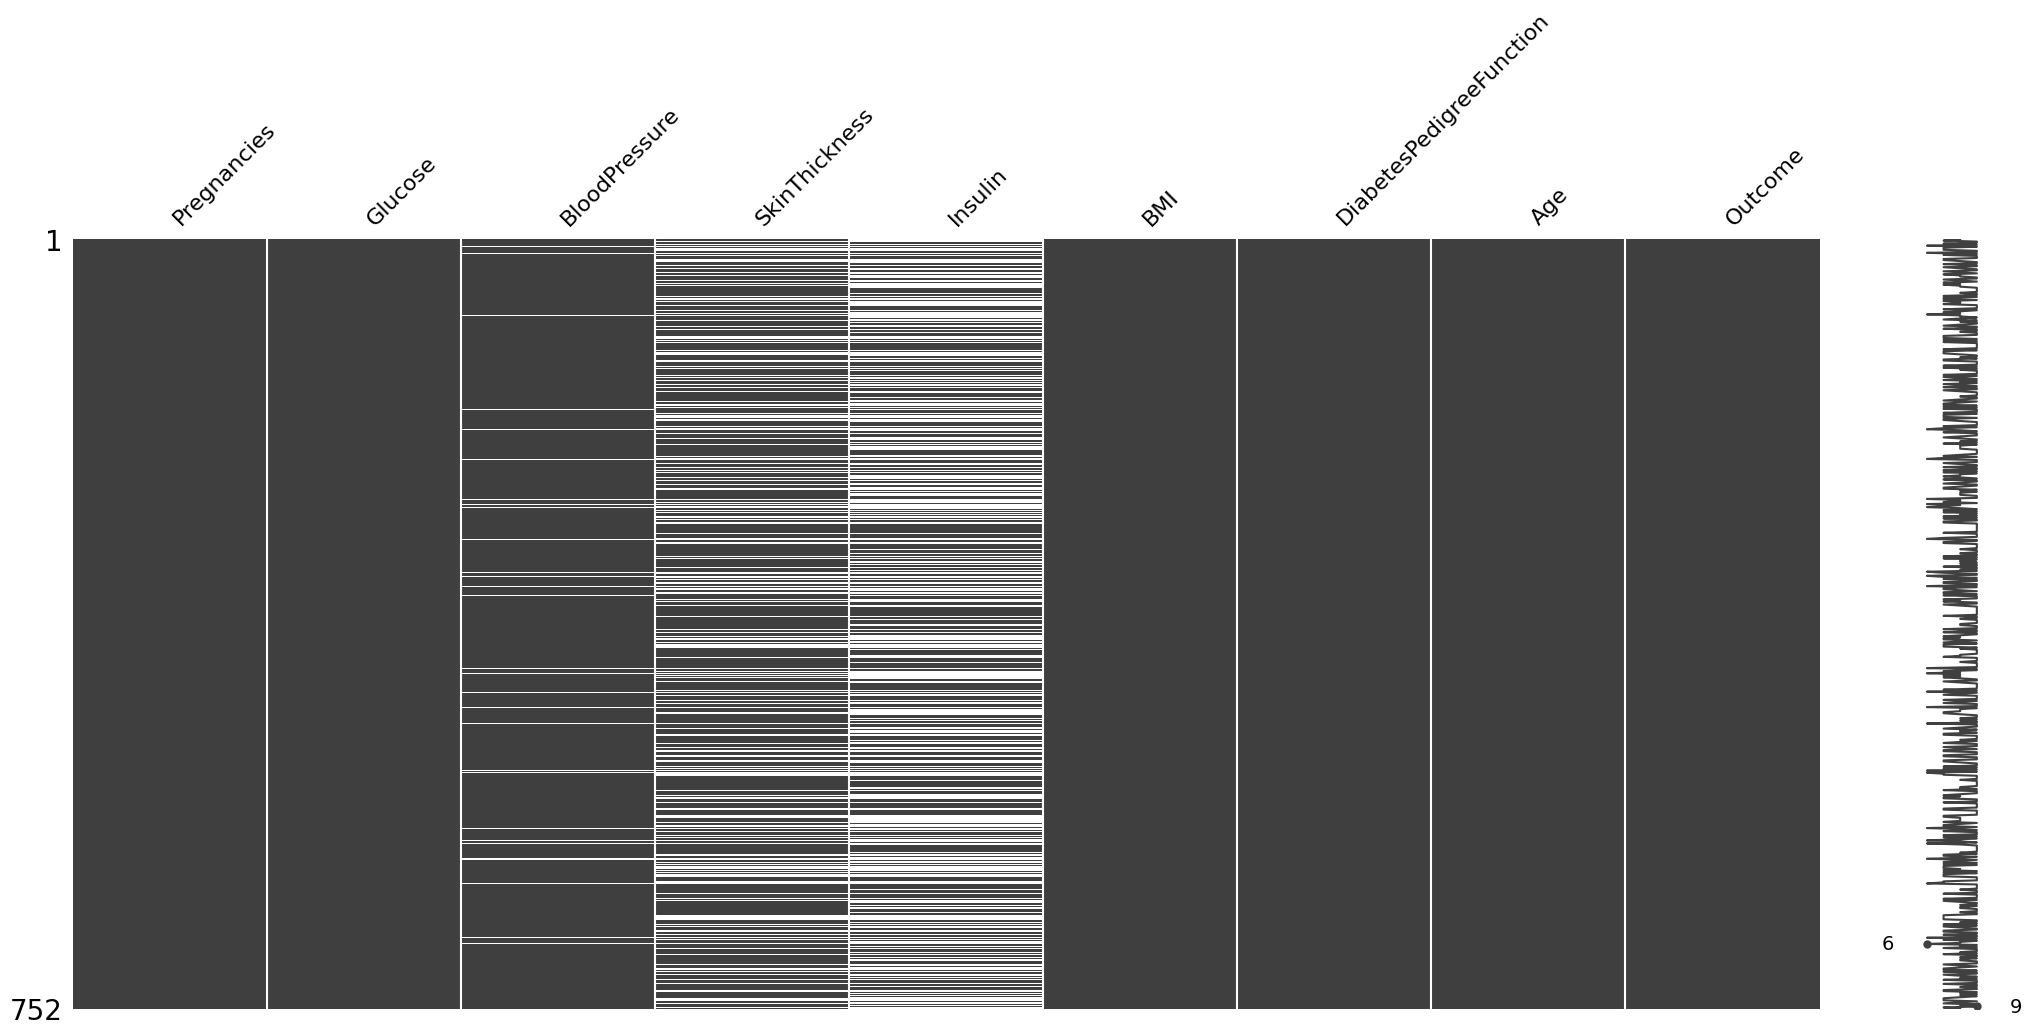

In [82]:
import missingno as msno
import matplotlib.pyplot as plt

# Plot a missingno matrix
msno.matrix(pima_df)
plt.show()


In [83]:
missing_percentage = (pima_df.isnull().sum() / len(pima_df)) * 100


In [84]:
missing_percentage

Pregnancies                  0.000000
Glucose                      0.000000
BloodPressure                3.723404
SkinThickness               28.989362
Insulin                     47.872340
BMI                          0.000000
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

In [ ]:
## Using one line only, work out the total percentage of missing values from the pima dataframe

Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

## Visualising Missing Data
There is a very useful package called `missingno` which allows us to easily visualise our data and identify rows where our data is missing. Doing this allows you to graphically visualise which rows have missing data, and can help us to determine whether data has gone missing because of a random error or because of something a bit more systematic.

Let's see how to use this library using first the `auto_df` and then the `pima_df` datasets.

In case it's not installed, make sure to install the library running the same command

In [85]:
!pip install missingno

<Axes: >

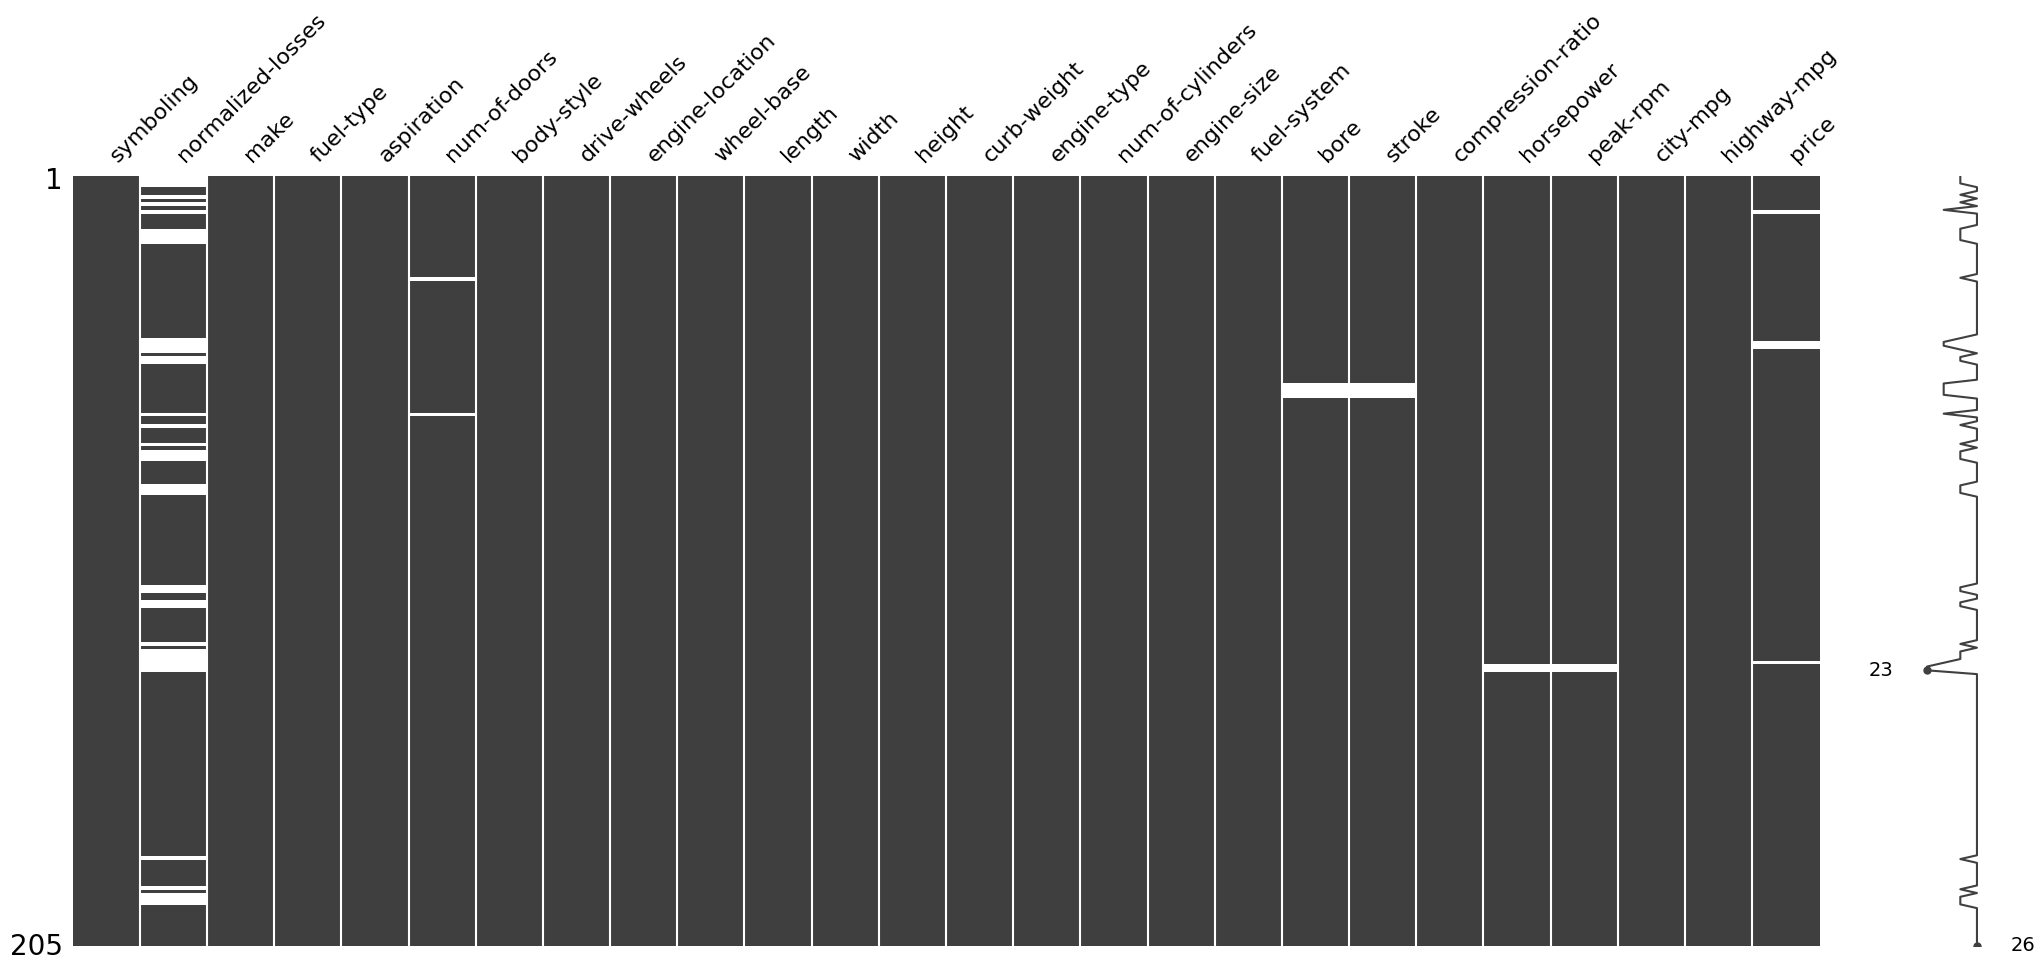

In [86]:
import missingno as msno

msno.matrix(auto_df)

In the auto_df dataset, we can see that the missing values don't follow a pattern, which most likely means that the data is missing due to random causes. This can be confirmed by looking at the missingno matrix. The matrix shows us that the missing values are randomly distributed across the dataset. The white lines indicate the missing values, and as shown in the matrix, the missing values are randomly distributed across the dataset.

Let's check the `pima_df` dataset now

<Axes: >

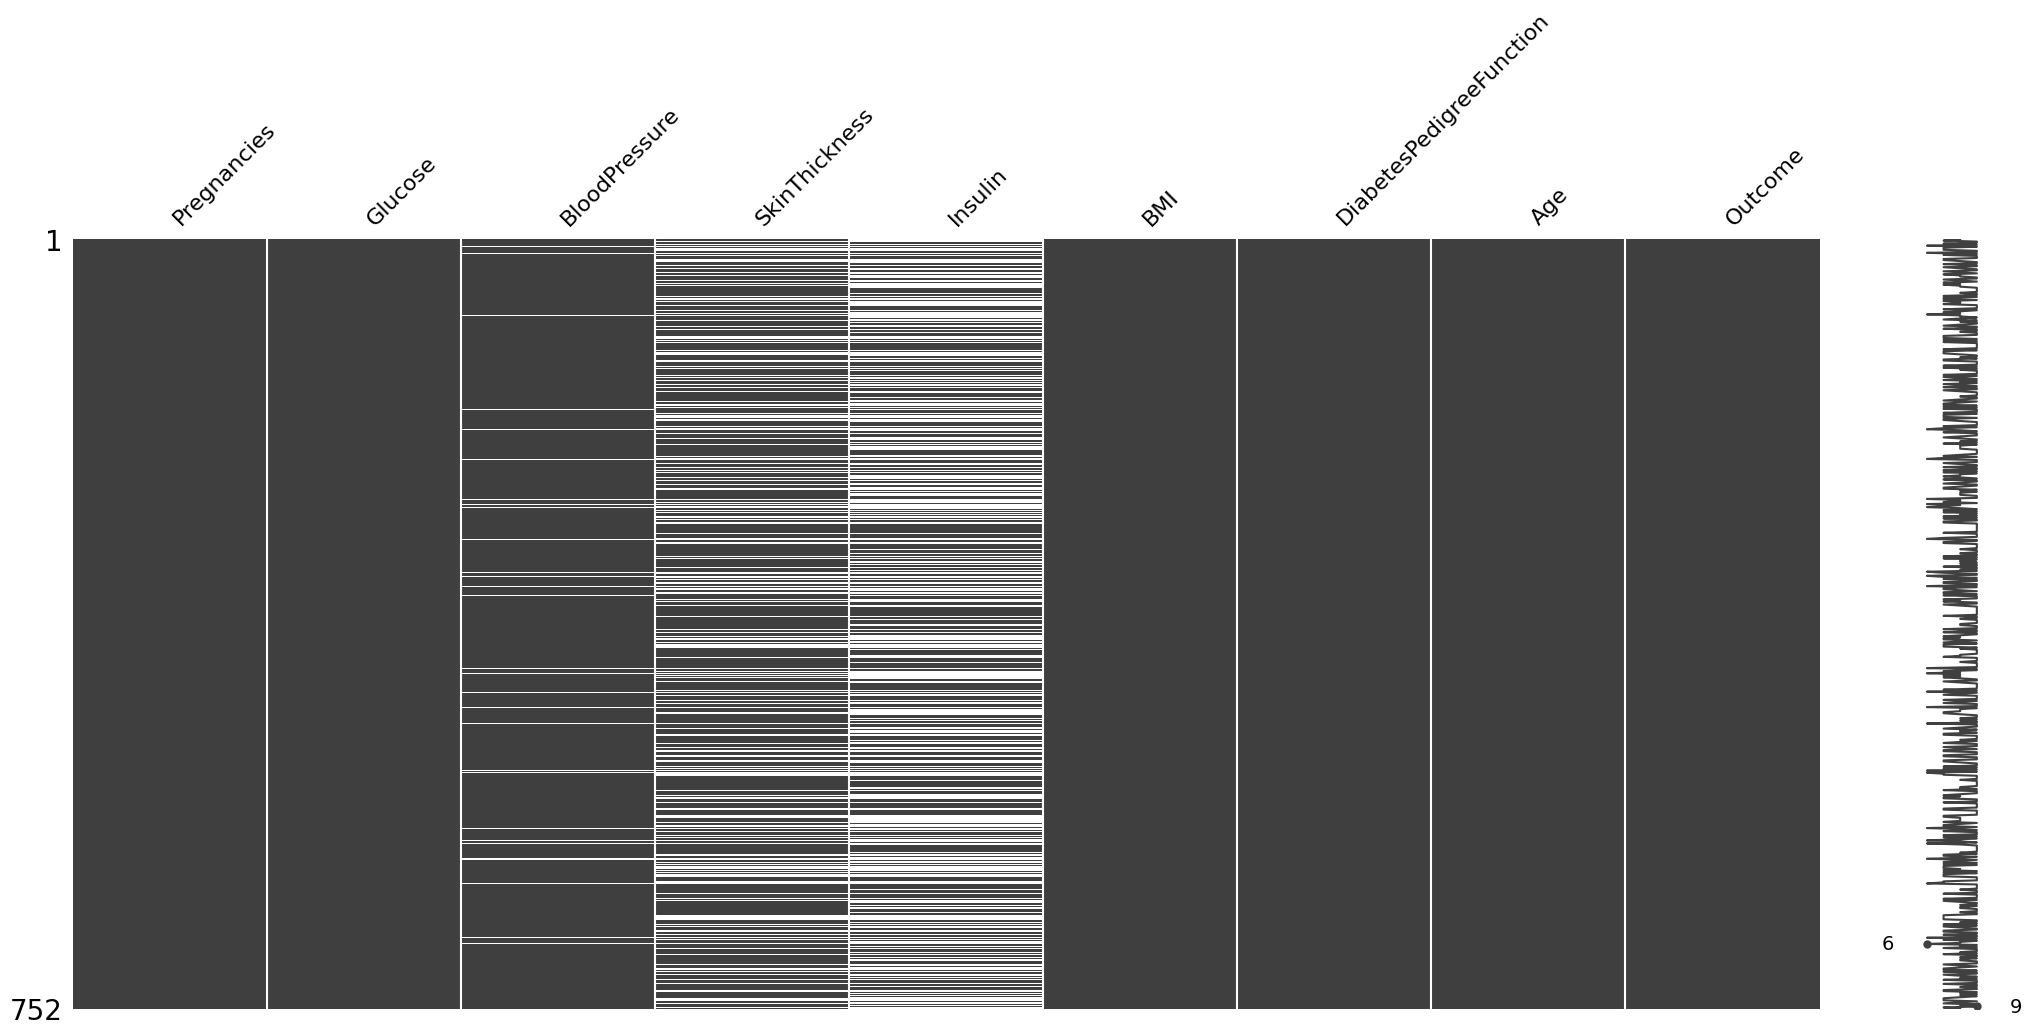

In [87]:
# msno.bar(pima_df)
msno.matrix(pima_df)

In the pima_df dataset, we can see that the missing values follow a pattern, whenever the SkinThickness is missing, the Insulin seems to be missing as well.

This is most likely because the data is missing due to systematic causes. The white lines in this case are not randomly distributed across the dataset.

## When (and how) to delete data

There are two types of deletion we can consider:

1. Pairwise Deletion
2. Listwise Deletion

**Pairwise deletion** is when missing values are skipped during the calculation of some statistic. This is almost a non-factor with Pandas because when we compute a statistic, missing values aren't considered:

In [88]:
print("Mean of Glucose using native mean method:", pima_df["Glucose"].mean())
print("Mean of Glucose via manual calculation  :", pima_df["Glucose"].sum() / pima_df["Glucose"].count())

Mean of Glucose using native mean method: 121.94148936170212
Mean of Glucose via manual calculation  : 121.94148936170212


**Listwise deletion** is when we drop the whole row of data because of a missing value. This is completely valid to do but should only be done when the amount of rows you are dropping is insignificant when compared to the rest of the dataset. From our counts of nullity that we did previously, and working under the knowledge that `Glucose` and `BMI` are MCAR, we are safe to drop the rows where these missing values are present.

In [89]:
# Drop rows with missing values in "Glucose" and "BMI" columns
pima_df.dropna(subset=["Glucose", "BMI"], inplace=True)


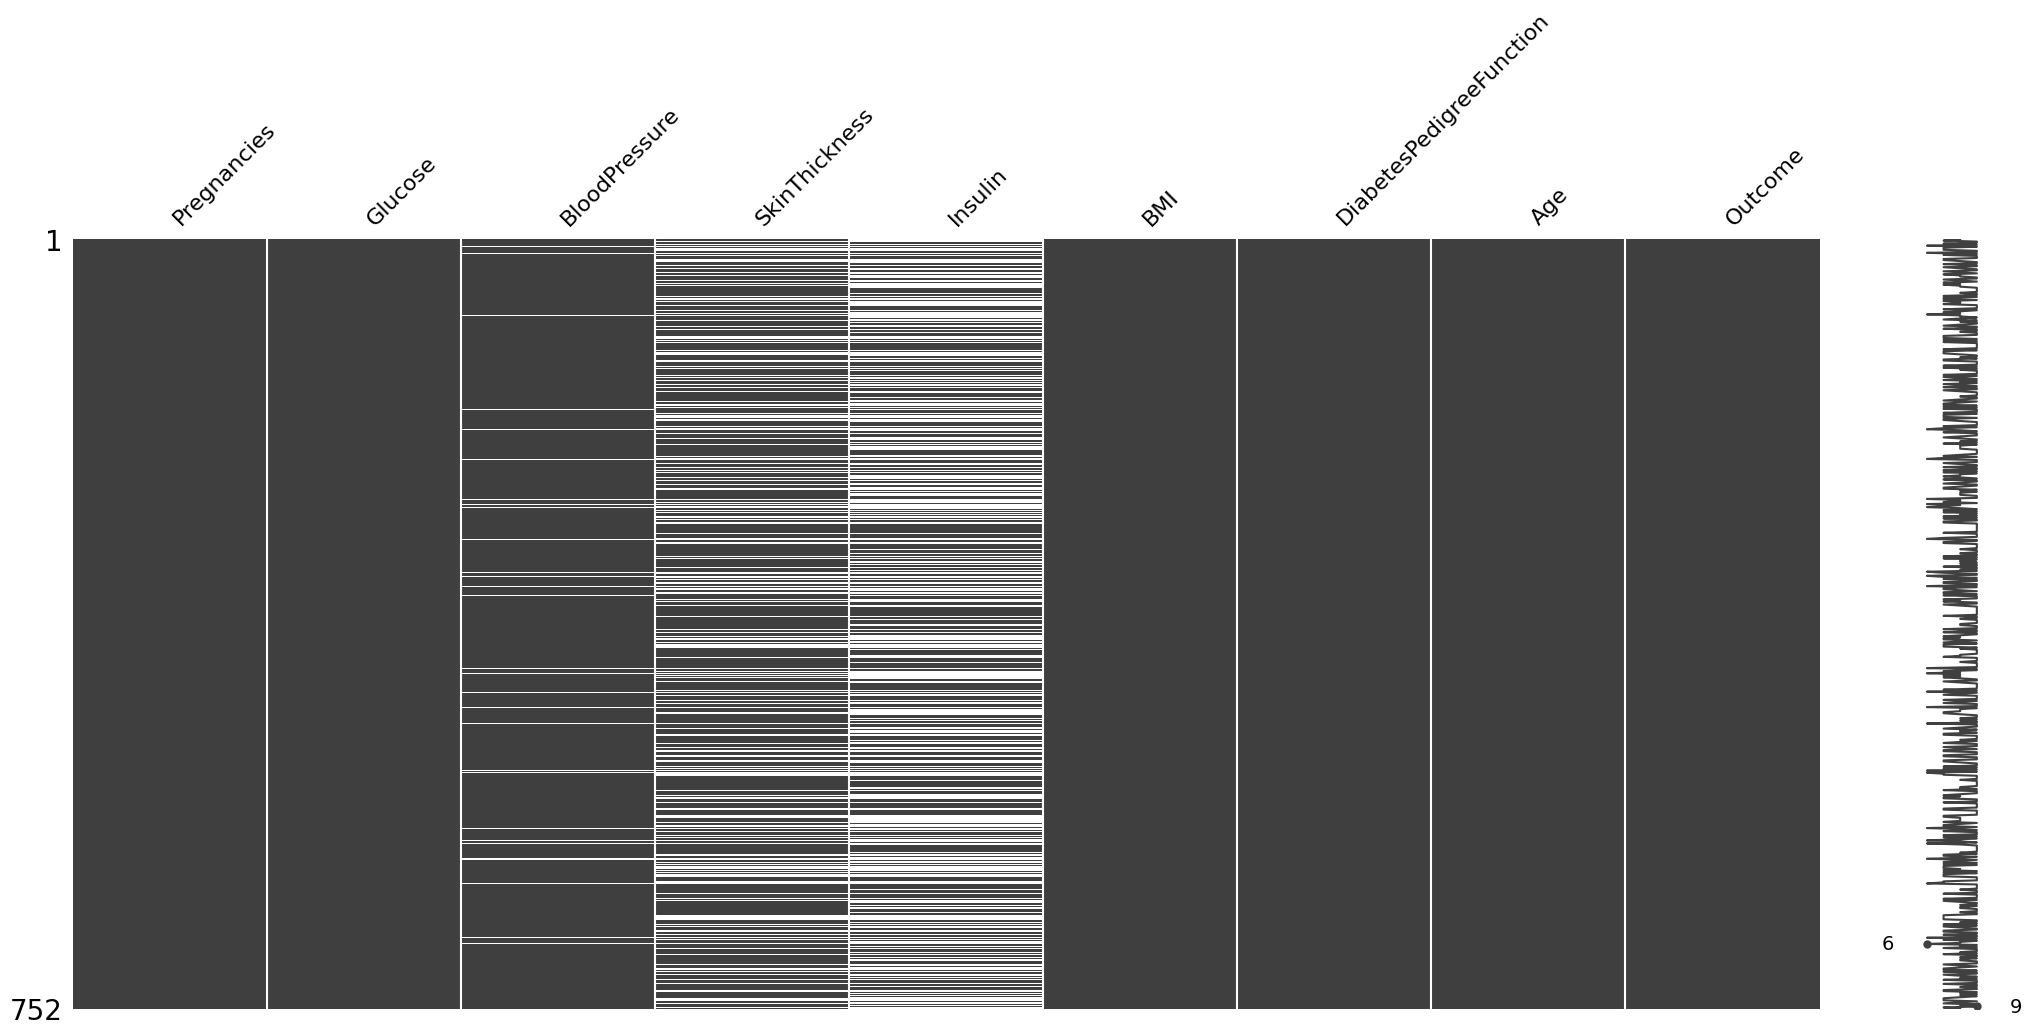

In [90]:
import missingno as msno
import matplotlib.pyplot as plt

# Plot a missingno matrix
msno.matrix(pima_df)
plt.show()


<AxesSubplot:>

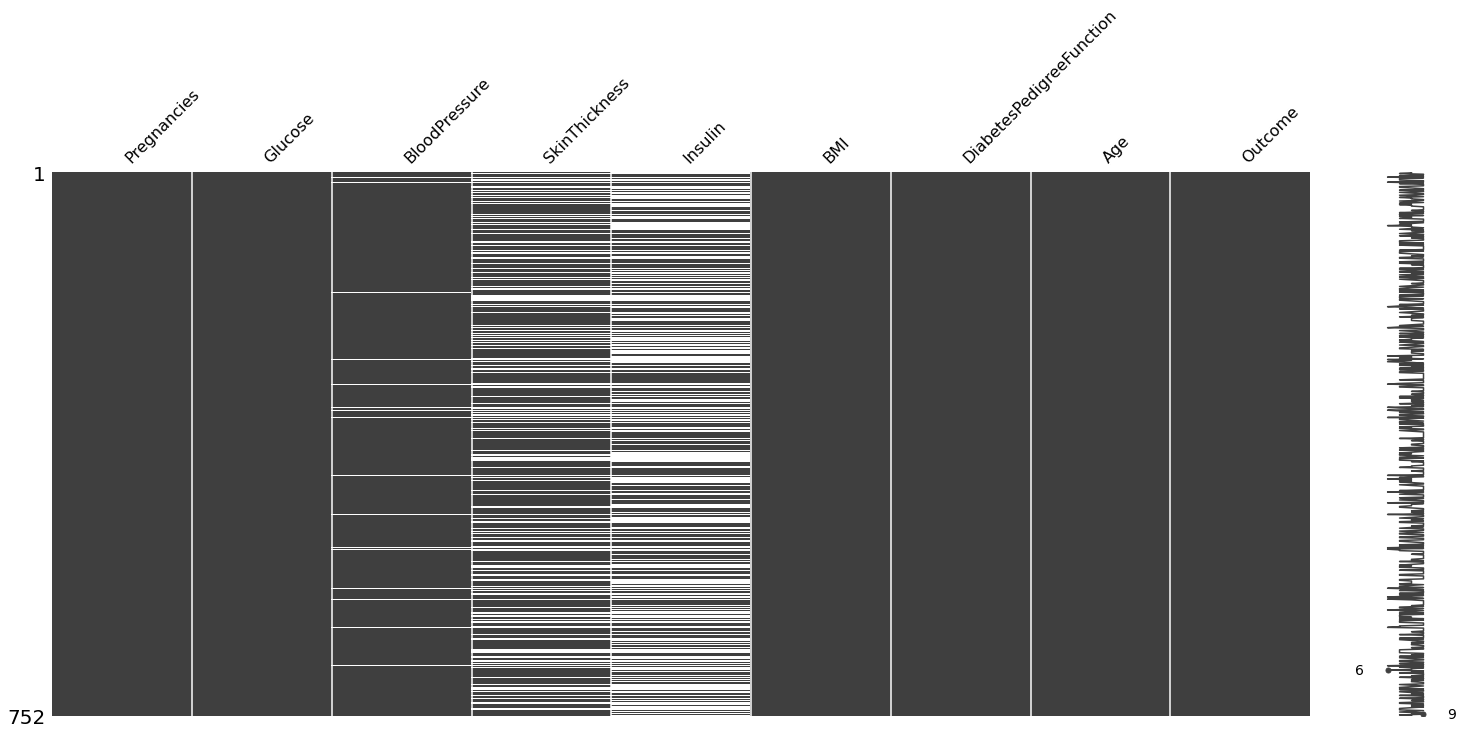

In [ ]:
## Drop the rows in Glucose and BMI for which there are missing values

## Plot a missingno matrix of the dataframe



## Imputing using averages

**Imputation** is the act of predicting the missing data, and can be applied to any of the missing data classifications we are working with. In this section, we will look at imputing data using central tendancy measures. We will show why this may not be a great idea, and then introduce ML imputing techniques. Recall the three types of average: Mean, Median and Mode.

The values of these types of imputations are trivial to calculate and we could easily do it ourselves if we wanted to. However, for the sake of introducing you to the API, we will be using skleanr's `SimpleImputer`.

In [91]:
pima_cols = pima_df.columns
pima_cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [92]:
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy="most_frequent")
pima_mode_arr = mode_imputer.fit_transform(pima_df)
pima_mode_df = pd.DataFrame(data=pima_mode_arr, columns=pima_cols)
pima_mode_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,105.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,105.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,32.0,105.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
747,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0
748,2.0,122.0,70.0,27.0,105.0,36.8,0.340,27.0,0.0
749,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0
750,1.0,126.0,60.0,32.0,105.0,30.1,0.349,47.0,1.0


In [93]:
## Impute and assign dataframes for strategies of mean and median
median_imputer = SimpleImputer(strategy="median")
pima_median_arr = median_imputer.fit_transform(pima_df)
pima_median_df = pd.DataFrame(data=pima_median_arr, columns=pima_cols)

### Your Code Here, do the same using the mean strategy

### So why is this bad?

Central tendancy imputations should be avoided because they reduce the variance of the data, leading to a higher bias in the data. Perhaps more intuitively, these types of imputations will not consider any of the other variable relationships in your data. We can easily see this with visualisations

In [94]:
nulls = (pima_df["SkinThickness"].isnull() + pima_df["BMI"].isnull()).astype("int")
px.scatter(pima_mean_df, x="SkinThickness", y="BMI", title="SkinThickness vs BMI (Mean Imputation)",
           color=nulls)

NameError: ignored

In [95]:
# Assuming pima_df is your original DataFrame
pima_mean_df = pima_df.copy()

# Mean imputation for SkinThickness and BMI columns
pima_mean_df["SkinThickness"].fillna(pima_mean_df["SkinThickness"].mean(), inplace=True)
pima_mean_df["BMI"].fillna(pima_mean_df["BMI"].mean(), inplace=True)

# Now, you can create the scatter plot
import plotly.express as px

nulls = (pima_mean_df["SkinThickness"].isnull() + pima_mean_df["BMI"].isnull()).astype("int")
px.scatter(pima_mean_df, x="SkinThickness", y="BMI", title="SkinThickness vs BMI (Mean Imputation)", color=nulls)


In [96]:
# Visualising the different imputations through subplots
from plotly.subplots import make_subplots

fig_mean = px.scatter(pima_mean_df, x="SkinThickness", y="BMI", color=nulls)

fig_median = px.scatter(pima_median_df, x="SkinThickness", y="BMI", color=nulls)

fig_mode = px.scatter(pima_mode_df, x="SkinThickness", y="BMI", color=nulls)

fig = make_subplots(rows=1, cols=3, shared_xaxes=False, subplot_titles=("Mean Imputation","Median Imputation", "Mode Imputation"))
fig.add_trace(fig_mean['data'][0], row=1, col=1)
fig.add_trace(fig_median['data'][0], row=1, col=2)
fig.add_trace(fig_mode['data'][0], row=1, col=3)
fig.update_layout(title="SkinThickness vs BMI (Imputations)")
fig.show()

### ML based imputation techniques

The alternative to using central tendencies or constant values for imputations is to use ML based imputation methods. We will cover three types algorithms here which have popular use: Nearest neighbours imputation, tree based imputation and regression based imputation. These methods work by building models for a feature based on the other features of the data.

We'll start with KNN imputation. Here, the algorithm selects the K nearest/most similar datapoints to a datapoint with a missing value. The missing value is then either populated with an average from the K neighbours, or a weighted average. This argument can be specified by `weights` flag in sklearn's [`KNNImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) class.

In [97]:
from sklearn.impute import KNNImputer

# default arguments are:
# n_neighbors = 5
# weights = "uniform"
knn_impute = KNNImputer(n_neighbors=3, weights="distance")
pima_knn_arr = knn_impute.fit_transform(pima_df)
pima_knn_df = pd.DataFrame(data=pima_knn_arr, columns=pima_cols)

fig_knn = px.scatter(pima_knn_df, x="SkinThickness", y="BMI", title="SkinThickness vs BMI (KNN Imputation)",
           color=nulls)
fig_knn

When researching imputation techniques, one common method you'll come across is something known as [**MICE**](https://www.jstatsoft.org/article/view/v045i03) - Multivariate Imputation by Chained Equations. This algorithm performs multiple regressions of a random sample of data, and uses the average of these multiple regressions to impute the missing value. With the sklearn API, the appropiate method to use is the [`IterativeImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) class, passing `sample_posterior=True` ([source](https://scikit-learn.org/stable/modules/impute.html))

In [98]:
# IterativeImputer is an experimental feature in sklearn, so we need to enable it prior to using it
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

regression_impute = IterativeImputer(sample_posterior=True)
pima_regression_arr = regression_impute.fit_transform(pima_df)
pima_regression_df = pd.DataFrame(data=pima_regression_arr, columns=pima_cols)

fig_br = px.scatter(pima_regression_df, x="SkinThickness", y="BMI", title="SkinThickness vs BMI (Regression Imputation)",
           color=nulls)
fig_br

The `IterativeImputer` class is highly flexible and allows us to use any estimator object to perform our imputation (instead of just regression). The default estimator that it uses isn't actually vanilla linear regression - it's something known as Bayesian Ridge regression. We won't cover the details here as the important thing to know is that it is just a linear regression variant. If you are curious about a fuller understanding, more details can be found at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge.

Another, more recent, trend in imputation is using tree based ensembles. Here we will use the `RandomForestRegressor` estimator to impute the missing values:

In [99]:
from sklearn.ensemble import RandomForestRegressor

## Impute the missing values using RandomForestRegressor and IterativeImputer

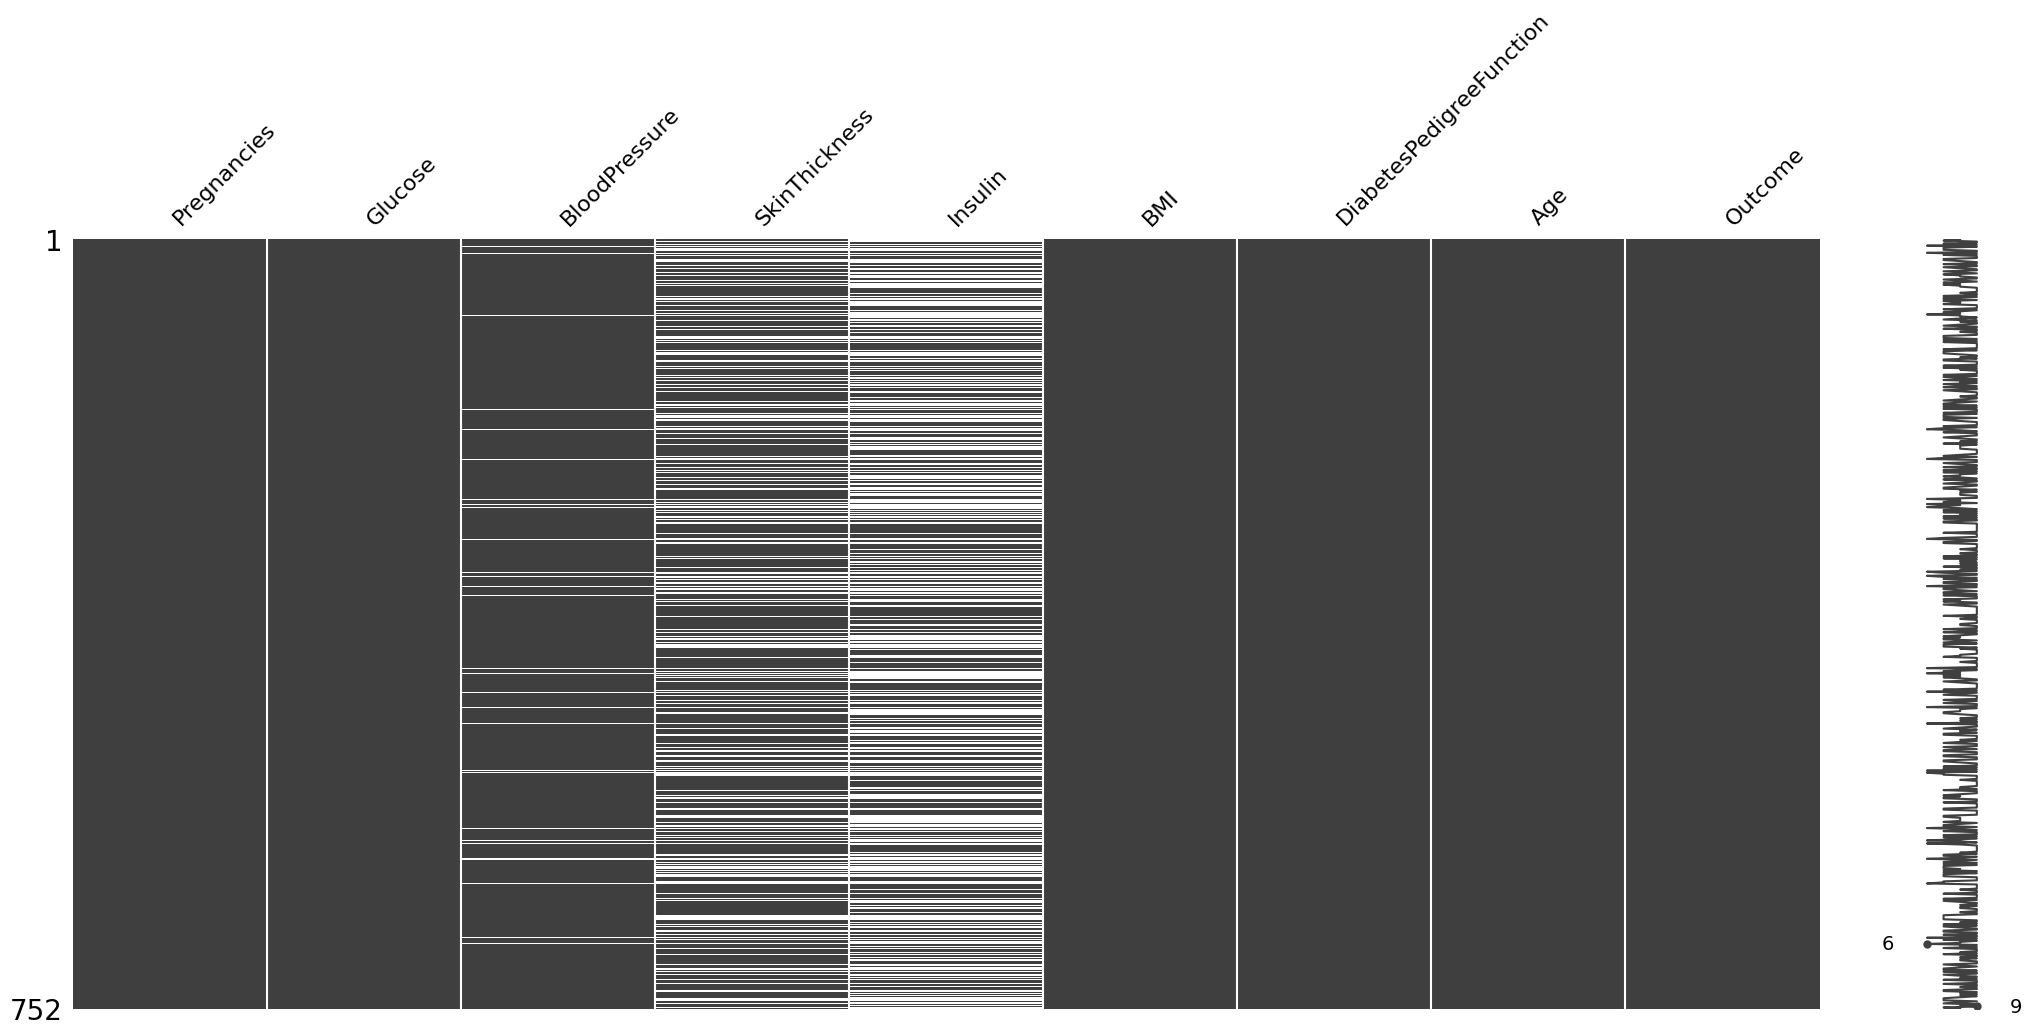

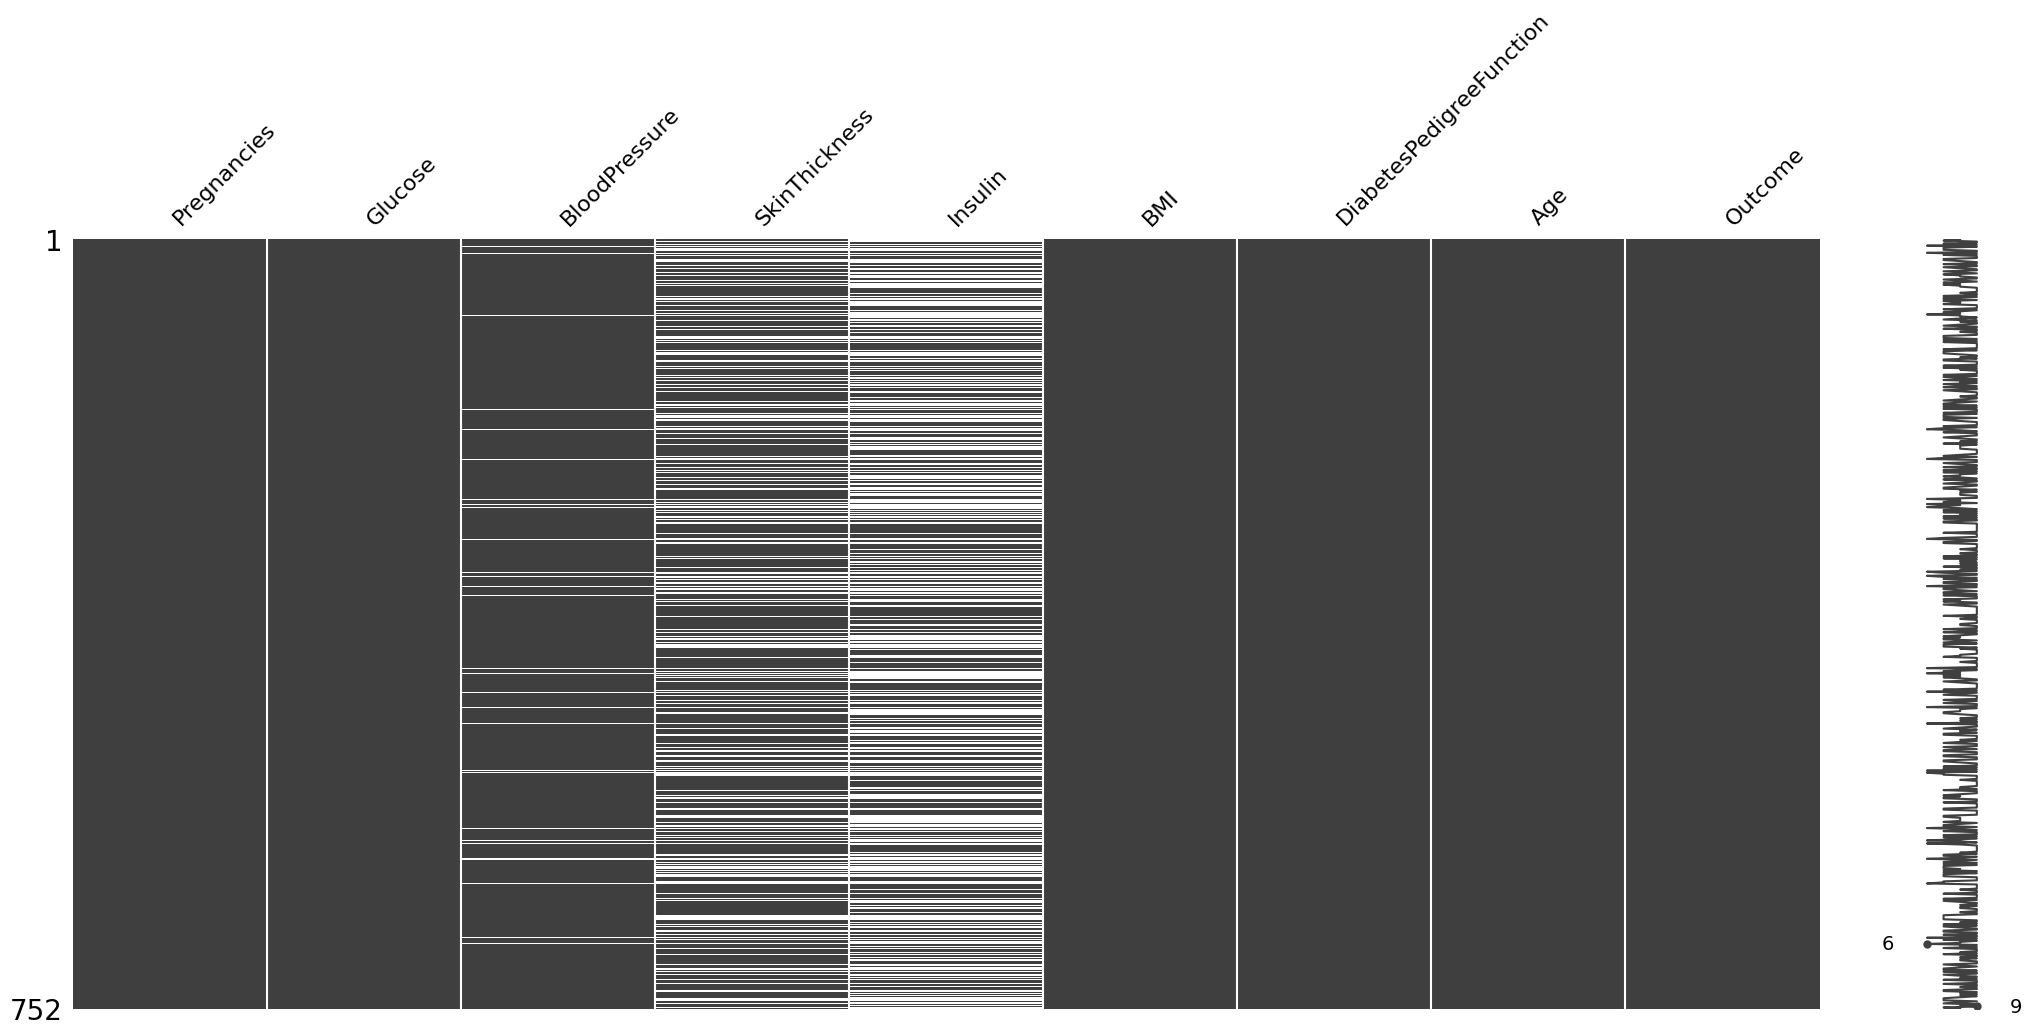

In [100]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Assuming pima_df is your DataFrame with missing values
# You may need to import missingno for visualization
import missingno as msno

# Display the missing data matrix before imputation
msno.matrix(pima_df)
plt.show()

# Select columns with missing values
columns_with_missing = ["Glucose", "BMI"]

# Create a copy of the DataFrame for imputation
pima_imputed_df = pima_df.copy()

# Initialize the IterativeImputer with RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)

# Impute missing values
pima_imputed_df[columns_with_missing] = imputer.fit_transform(pima_imputed_df[columns_with_missing])

# Display the missing data matrix after imputation
msno.matrix(pima_imputed_df)
plt.show()


In [ ]:
fig = make_subplots(rows=1, cols=3, shared_xaxes=False, subplot_titles=("KNN Imputation", "BR Regression Imputation", "RF Regression Imputation"))
fig.add_trace(fig_knn['data'][0], row=1, col=1)
fig.add_trace(fig_br['data'][0], row=1, col=2)
fig.add_trace(fig_rf['data'][0], row=1, col=3)
fig.update_layout(title="SkinThickness vs BMI (Regression Imputations)")
fig.show()

## Time Series Imputation

Time series data referes to data that has been collected over time, with each datapoint being indexed by a sequential datetime. The most typical example is perhaps stock data. Here, we will look at the Beijing PM2.5. In the `.read_csv()` method, we'll tell Pandas that we want to index on the Date variable

In [101]:
pm_df_org = pd.read_csv("Beijing_PM.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)

In [102]:
pm_df = pm_df_org[:400000]
pm_df = pm_df.loc[~pm_df.index.duplicated(keep='last')]
pm_df = pm_df.sort_index(axis=0)
pm_df

,City,Country,Season,PM2.5 concentration (ug/m^3),Dew Point (Fahrenheit),Temperature (Fahrenheit),Humidity (%),Pressure (hPa),Wind Direction,Wind Speed (m/s),"Precipitation (mm, hourly)","Precipitation (mm, Cumulated)"
Date,,,,,,,,,,,,
2013-03-01 00:00:00,Beijing,China,Winter,5.0,-6.52,32.0,NaN,1024.0,NNW,5.7,0.0,NaN
2013-03-01 01:00:00,Beijing,China,Winter,8.0,-7.78,32.0,NaN,1025.0,NW,3.9,0.0,NaN
2013-03-01 02:00:00,Beijing,China,Winter,3.0,-12.28,30.2,NaN,1025.0,NNW,5.3,0.0,NaN
2013-03-01 03:00:00,Beijing,China,Winter,5.0,-13.90,30.2,NaN,1026.0,N,4.9,0.0,NaN
2013-03-01 04:00:00,Beijing,China,Winter,5.0,-12.10,30.2,NaN,1027.0,NNW,3.2,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,Beijing,China,Winter,16.0,2.84,53.6,NaN,1013.0,NW,2.4,0.0,NaN
2017-02-28 20:00:00,Beijing,China,Winter,18.0,4.82,51.8,NaN,1013.0,WNW,0.9,0.0,NaN
2017-02-28 21:00:00,Beijing,China,Winter,23.0,8.06,50.0,NaN,1014.0,NW,1.1,0.0,NaN


In [104]:
# Calculate the percentage of null values in each column
null_percentage = (pm_df.isnull().sum() / len(pm_df)) * 100

# Display the result
print(null_percentage)


City                               0.000000
Country                            0.000000
Season                             0.000000
PM2.5 concentration (ug/m^3)       0.000000
Dew Point (Fahrenheit)             0.057179
Temperature (Fahrenheit)           0.057179
Humidity (%)                     100.000000
Pressure (hPa)                     0.057179
Wind Direction                     0.225856
Wind Speed (m/s)                   0.040025
Precipitation (mm, hourly)         0.057179
Precipitation (mm, Cumulated)    100.000000
dtype: float64


In [ ]:
## Check the percentage of nulls in each column

City                               0.000000
Country                            0.000000
Season                             0.000000
PM2.5 concentration (ug/m^3)       0.000000
Dew Point (Fahrenheit)             0.057179
Temperature (Fahrenheit)           0.057179
Humidity (%)                     100.000000
Pressure (hPa)                     0.057179
Wind Direction                     0.225856
Wind Speed (m/s)                   0.040025
Precipitation (mm, hourly)         0.057179
Precipitation (mm, Cumulated)    100.000000
dtype: float64

In [105]:
# Renaming columns so they're easier to refer to
pm_cols = ["city", "country", "season", "pm25", "dew_point", "temperature", "humidity", "pressure", "wind_direction", "wind_speed", "precipitation_hourly", "preciptiation_cum"]
pm_df.columns = pm_cols
pm_df.head()

,city,country,season,pm25,dew_point,temperature,humidity,pressure,wind_direction,wind_speed,precipitation_hourly,preciptiation_cum
Date,,,,,,,,,,,,
2013-03-01 00:00:00,Beijing,China,Winter,5.0,-6.52,32.0,NaN,1024.0,NNW,5.7,0.0,NaN
2013-03-01 01:00:00,Beijing,China,Winter,8.0,-7.78,32.0,NaN,1025.0,NW,3.9,0.0,NaN
2013-03-01 02:00:00,Beijing,China,Winter,3.0,-12.28,30.2,NaN,1025.0,NNW,5.3,0.0,NaN
2013-03-01 03:00:00,Beijing,China,Winter,5.0,-13.90,30.2,NaN,1026.0,N,4.9,0.0,NaN
2013-03-01 04:00:00,Beijing,China,Winter,5.0,-12.10,30.2,NaN,1027.0,NNW,3.2,0.0,NaN


### Fill missing values

We will start with the [`.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) method. The `.fillna()` method does what the name implies - it fills values where there is a NaN. This method has two strategies we can adopt:
- `ffill`
- `bfill`

Which stand for "forward fill" and "backward fill" respectively. If we have a Series with some missing values in it, `ffill` will replace the NaNs with the last non-NaN value we've come across in the Series - until the next non-NaN value is reached. Backward fill reverses this and fills in the non-NaN values with the *next* non-NaN value we would observe. Seeing this in action will clarify this description:

In [106]:
# Let's use a range from 31230 to 31245
pm_ffill_df = pm_df.fillna(method="ffill")
pm_ffill_df["wind_speed"][31230:31245]

Date
2016-09-25 13:00:00    2.0
2016-09-25 14:00:00    0.6
2016-09-25 15:00:00    2.1
2016-09-25 16:00:00    1.3
2016-09-25 17:00:00    1.3
2016-09-25 18:00:00    1.3
2016-09-25 19:00:00    1.3
2016-09-25 20:00:00    1.3
2016-09-25 21:00:00    1.3
2016-09-25 22:00:00    1.3
2016-09-25 23:00:00    1.3
2016-09-26 00:00:00    2.4
2016-09-26 01:00:00    1.9
2016-09-26 02:00:00    0.6
2016-09-26 03:00:00    1.1
Name: wind_speed, dtype: float64

In [108]:
import pandas as pd

# Assuming you have a DataFrame named pm_df_org

pm_df = pm_df_org[:400000]
pm_df = pm_df.loc[~pm_df.index.duplicated(keep='last')]
pm_df = pm_df.sort_index(axis=0)

pm_df


,City,Country,Season,PM2.5 concentration (ug/m^3),Dew Point (Fahrenheit),Temperature (Fahrenheit),Humidity (%),Pressure (hPa),Wind Direction,Wind Speed (m/s),"Precipitation (mm, hourly)","Precipitation (mm, Cumulated)"
Date,,,,,,,,,,,,
2013-03-01 00:00:00,Beijing,China,Winter,5.0,-6.52,32.0,NaN,1024.0,NNW,5.7,0.0,NaN
2013-03-01 01:00:00,Beijing,China,Winter,8.0,-7.78,32.0,NaN,1025.0,NW,3.9,0.0,NaN
2013-03-01 02:00:00,Beijing,China,Winter,3.0,-12.28,30.2,NaN,1025.0,NNW,5.3,0.0,NaN
2013-03-01 03:00:00,Beijing,China,Winter,5.0,-13.90,30.2,NaN,1026.0,N,4.9,0.0,NaN
2013-03-01 04:00:00,Beijing,China,Winter,5.0,-12.10,30.2,NaN,1027.0,NNW,3.2,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,Beijing,China,Winter,16.0,2.84,53.6,NaN,1013.0,NW,2.4,0.0,NaN
2017-02-28 20:00:00,Beijing,China,Winter,18.0,4.82,51.8,NaN,1013.0,WNW,0.9,0.0,NaN
2017-02-28 21:00:00,Beijing,China,Winter,23.0,8.06,50.0,NaN,1014.0,NW,1.1,0.0,NaN


In [114]:
# Print the column names of your DataFrame
print(pm_df.columns)


Index(['City', 'Country', 'Season', 'PM2.5 concentration (ug/m^3)',
       'Dew Point (Fahrenheit)', 'Temperature (Fahrenheit)', 'Humidity (%)',
       'Pressure (hPa)', 'Wind Direction', 'Wind Speed (m/s)',
       'Precipitation (mm, hourly)', 'Precipitation (mm, Cumulated)'],
      dtype='object')


In [115]:
# Assuming pm_df is your DataFrame
pm_bfill_df = pm_df.bfill()

# Display a specific range of the "wind_speed" column after backward fill
pm_bfill_df["Wind Speed (m/s)"][31230:31245]


Date
2016-09-25 13:00:00    2.0
2016-09-25 14:00:00    0.6
2016-09-25 15:00:00    2.1
2016-09-25 16:00:00    1.3
2016-09-25 17:00:00    1.3
2016-09-25 18:00:00    1.3
2016-09-25 19:00:00    2.4
2016-09-25 20:00:00    2.4
2016-09-25 21:00:00    2.4
2016-09-25 22:00:00    2.4
2016-09-25 23:00:00    2.4
2016-09-26 00:00:00    2.4
2016-09-26 01:00:00    1.9
2016-09-26 02:00:00    0.6
2016-09-26 03:00:00    1.1
Name: Wind Speed (m/s), dtype: float64

In [112]:
# Print the column names of your DataFrame
print(pm_df.columns)


Index(['City', 'Country', 'Season', 'PM2.5 concentration (ug/m^3)',
       'Dew Point (Fahrenheit)', 'Temperature (Fahrenheit)', 'Humidity (%)',
       'Pressure (hPa)', 'Wind Direction', 'Wind Speed (m/s)',
       'Precipitation (mm, hourly)', 'Precipitation (mm, Cumulated)'],
      dtype='object')


### Interpolation

Ok - so this works to fill NA values, but it's not really ideal. (Note that the fillna method has applications outside of time series data). The next level up is the [`.interpolation()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) function. Interpolation is art of finding a transition from one point to the other. `.interpolation()` has many useful techniques to interpolate datapoints, but we will focus on the following 3. Refer to the documentation for a more comprehensive list, and the recommended place for when to use the method:
- Linear
- Quadratic
- Nearest

#### Linear
Linear interpolation simply fills values with equidistant points from the first non-NaN value to the next. Visually:
![](https://github.com/AI-Core/Content-Public/blob/main/Content/units/Data-Handling/2.%20Data%20Manipulation%20with%20Pandas/images/linear_interpolation.png?raw=1)

It would be trivial to calculate what this 'equidistant' value actually is - we take the first non-NaN value and the following non-NaN value, subtract the two together, and divide it by the number of NaNs between the two points. With the `wind_speed` data we were looking at, this would be $(2.4 - 1.3)/6 = 0.183$.

In [117]:
pm_linear_df = pm_df.interpolate(method="linear")
pm_linear_df["Wind Speed (m/s)"][31230:31245]

Date
2016-09-25 13:00:00    2.000000
2016-09-25 14:00:00    0.600000
2016-09-25 15:00:00    2.100000
2016-09-25 16:00:00    1.300000
2016-09-25 17:00:00    1.300000
2016-09-25 18:00:00    1.300000
2016-09-25 19:00:00    1.483333
2016-09-25 20:00:00    1.666667
2016-09-25 21:00:00    1.850000
2016-09-25 22:00:00    2.033333
2016-09-25 23:00:00    2.216667
2016-09-26 00:00:00    2.400000
2016-09-26 01:00:00    1.900000
2016-09-26 02:00:00    0.600000
2016-09-26 03:00:00    1.100000
Name: Wind Speed (m/s), dtype: float64

#### Nearest

The `nearest` strategy is very similar to that of `.fillna()` in that it fills the values. However, this method simply fills in the NaNs with the closest non-NaN value to the current NaN  we're looping over.

#### Quadratic
Quadratic interpolation attempts to fit a quadratic/parabolic curve between the two non-NaN values. Later in this notebook we will show plots of the different interpolation methods and you'll be able to get a better sense of understanding how and where each of the interpolation methods we are presenting would be useful. We won't be diving into the methodology behind quadratic interpolation, but you can find a brilliant walkthrough here: https://www.youtube.com/watch?v=ifS8LL3qT2g

![](https://github.com/AI-Core/Content-Public/blob/main/Content/units/Data-Handling/2.%20Data%20Manipulation%20with%20Pandas/images/quadratic_interpolation.png?raw=1)

### Visualising Time-series data


In [121]:
pm_df["Wind Speed (m/s)"][31230:31245]

Date
2016-09-25 13:00:00    2.0
2016-09-25 14:00:00    0.6
2016-09-25 15:00:00    2.1
2016-09-25 16:00:00    1.3
2016-09-25 17:00:00    1.3
2016-09-25 18:00:00    1.3
2016-09-25 19:00:00    NaN
2016-09-25 20:00:00    NaN
2016-09-25 21:00:00    NaN
2016-09-25 22:00:00    NaN
2016-09-25 23:00:00    NaN
2016-09-26 00:00:00    2.4
2016-09-26 01:00:00    1.9
2016-09-26 02:00:00    0.6
2016-09-26 03:00:00    1.1
Name: Wind Speed (m/s), dtype: float64

In [123]:
pd.options.plotting.backend = 'plotly'

fig = make_subplots(rows=6, cols=1, shared_xaxes=False, subplot_titles=("None", "Ffill Interpoloation", "Bfill Interpoloation", "Linear Interpoloation", "Nearest Interpoloation", "Quadratic Interpoloation"))

default = pm_df["Wind Speed (m/s)"][31230:31245]

fig_none = default.plot()
fig.add_trace(fig_none["data"][0], row=1, col=1)

figs_list = [pm_ffill_df, pm_bfill_df, pm_linear_df, pm_nearest_df, pm_quad_df]
for i, to_fig in enumerate(figs_list):
    fig_ = to_fig["Wind Speed (m/s)"][31230:31245].plot(color_discrete_sequence=["red"])
    fig_.add_trace(px.line(pm_df["Wind Speed (m/s)"][31230:31245]).data[0])

    fig.add_trace(fig_["data"][0], row=i+2, col=1)
    fig.add_trace(fig_["data"][1], row=i+2, col=1)

fig.update_layout(title="Wind Speed Interpolations", width=np.inf, height=1600, showlegend=False)
fig.update_traces(mode='markers+lines')
fig.show()

# fig = pm_df.interpolate(method="quadratic")["wind_speed"][31230:31245].plot()
# fig.add_trace(px.line(pm_df["wind_speed"][31230:31245], color_discrete_sequence=["red"]).data[0])
# fig.show()

NameError: ignored

## Imputing Categorical Variables
A naive approach to impute categorical data is to either use the most frequent/mode method or the `.fillna()` strategy that we looked at earlier. However, it is possible to impute categorical variables as we would a typical continuous variable. We cannot directly perform the imputation as straightforwardly as before because the categorical variables are usually encoded as strings (and therefore we can not perform any mathematical operations on them). To impute these kinds of variables, we must first encode them them as numeric values.

In [124]:
from sklearn.preprocessing import OrdinalEncoder
knn_impute = KNNImputer(n_neighbors=3, weights="distance")

# We will drop city and country because these are categorical variables which have all their values present
# We will keep season even though it has all the values present (just to demonstrate the process over multiple categorical variables)
# We will drop humidity and precipitation_cum as these features are fully NaN
pm_to_impute_cols = ["season", "pm25", "dew_point", "temperature", "pressure", "wind_direction", "wind_speed", "precipitation_hourly"]
pm_to_impute_df = pm_df[pm_to_impute_cols]
cat_cols = ["season", "wind_direction"]

# key: col, value: list of tuples
category_dict_encode = {}
category_dict_decode = {}
for col in cat_cols:
    pm_to_impute_df[col] = pm_to_impute_df[col].astype("category")
    categories = pm_to_impute_df[col].cat.categories

    col_cat_dict = dict(enumerate(categories))
    print("Column, Category dict:", col_cat_dict)
    category_dict_decode[col] = col_cat_dict

    col_cat_dict = {v:k for k,v in col_cat_dict.items()}
    print("Inverted Column, Category dict:", col_cat_dict)
    category_dict_encode[col] = col_cat_dict

print()
print("Category dict ENCODE:", category_dict_encode)
print("Category dict DECODE:", category_dict_decode)
pm_to_impute_df.replace(category_dict_encode, inplace=True)
pm_to_impute_df


KeyError: ignored

In [125]:
knn_pm_arr = knn_impute.fit_transform(pm_to_impute_df)
knn_pm_df = pd.DataFrame(knn_pm_arr, columns = pm_to_impute_cols)
knn_pm_df[31230:31245]

NameError: ignored

In [ ]:
for col in cat_cols:
    knn_pm_df[col] = knn_pm_df[col].round()
knn_pm_df.index = pm_df.index
knn_pm_df[31230:31245]

,season,pm25,dew_point,temperature,pressure,wind_direction,wind_speed,precipitation_hourly
Date,,,,,,,,
2016-09-25 13:00:00,0.0,173.0,66.3800,77.000,1010.000000,5.0,2.000000,0.0
2016-09-25 14:00:00,0.0,163.0,64.7600,78.800,1010.000000,4.0,0.600000,0.0
2016-09-25 15:00:00,0.0,168.0,64.5800,78.800,1009.000000,4.0,2.100000,0.0
2016-09-25 16:00:00,0.0,189.0,65.1200,80.600,1009.000000,7.0,1.300000,0.0
2016-09-25 17:00:00,0.0,200.0,66.3800,78.800,1009.000000,4.0,1.300000,0.0
2016-09-25 18:00:00,0.0,176.0,67.2800,78.800,1009.000000,4.0,1.300000,0.0
2016-09-25 19:00:00,0.0,183.0,53.5400,63.800,1004.666667,2.0,1.233333,0.0
2016-09-25 20:00:00,0.0,143.0,53.4200,76.400,1009.666667,8.0,2.100000,0.0
2016-09-25 21:00:00,0.0,106.0,18.6200,47.000,1008.333333,9.0,1.566667,0.0


In [ ]:
# In the original dataframe we will only replace the values for the categorical cols we imputed
# We need to map the columns back to their codes
knn_pm_df.replace(category_dict_decode, inplace=True)
knn_pm_df[31230:31245]

,season,pm25,dew_point,temperature,pressure,wind_direction,wind_speed,precipitation_hourly
Date,,,,,,,,
2016-09-25 13:00:00,Winter,173.0,66.3800,77.000,1010.000000,NNE,2.000000,0.0
2016-09-25 14:00:00,Winter,163.0,64.7600,78.800,1010.000000,NE,0.600000,0.0
2016-09-25 15:00:00,Winter,168.0,64.5800,78.800,1009.000000,NE,2.100000,0.0
2016-09-25 16:00:00,Winter,189.0,65.1200,80.600,1009.000000,NW,1.300000,0.0
2016-09-25 17:00:00,Winter,200.0,66.3800,78.800,1009.000000,NE,1.300000,0.0
2016-09-25 18:00:00,Winter,176.0,67.2800,78.800,1009.000000,NE,1.300000,0.0
2016-09-25 19:00:00,Winter,183.0,53.5400,63.800,1004.666667,ESE,1.233333,0.0
2016-09-25 20:00:00,Winter,143.0,53.4200,76.400,1009.666667,S,2.100000,0.0
2016-09-25 21:00:00,Winter,106.0,18.6200,47.000,1008.333333,SE,1.566667,0.0


In [ ]:
imputed_cols_df = knn_pm_df[cat_cols]
imputed_cols_df

,season,wind_direction
Date,,
2013-03-01 00:00:00,Winter,NNW
2013-03-01 01:00:00,Winter,NW
2013-03-01 02:00:00,Winter,NNW
2013-03-01 03:00:00,Winter,N
2013-03-01 04:00:00,Winter,NNW
...,...,...
2017-02-28 19:00:00,Winter,NW
2017-02-28 20:00:00,Winter,WNW
2017-02-28 21:00:00,Winter,NW


In [ ]:
pm_imputed_df = pm_df.copy(deep=True)
pm_imputed_df.update(knn_pm_df, overwrite=False)
pm_imputed_df[31230:31245]

,city,country,season,pm25,dew_point,temperature,humidity,pressure,wind_direction,wind_speed,precipitation_hourly,preciptiation_cum
Date,,,,,,,,,,,,
2016-09-25 13:00:00,Beijing,China,Winter,173.0,66.3800,77.000,NaN,1010.000000,NNE,2.000000,0.0,NaN
2016-09-25 14:00:00,Beijing,China,Winter,163.0,64.7600,78.800,NaN,1010.000000,NE,0.600000,0.0,NaN
2016-09-25 15:00:00,Beijing,China,Winter,168.0,64.5800,78.800,NaN,1009.000000,NE,2.100000,0.0,NaN
2016-09-25 16:00:00,Beijing,China,Winter,189.0,65.1200,80.600,NaN,1009.000000,NW,1.300000,0.0,NaN
2016-09-25 17:00:00,Beijing,China,Winter,200.0,66.3800,78.800,NaN,1009.000000,NE,1.300000,0.0,NaN
2016-09-25 18:00:00,Beijing,China,Winter,176.0,67.2800,78.800,NaN,1009.000000,NE,1.300000,0.0,NaN
2016-09-25 19:00:00,Beijing,China,Winter,183.0,53.5400,63.800,NaN,1004.666667,ESE,1.233333,0.0,NaN
2016-09-25 20:00:00,Beijing,China,Winter,143.0,53.4200,76.400,NaN,1009.666667,S,2.100000,0.0,NaN
2016-09-25 21:00:00,Beijing,China,Winter,106.0,18.6200,47.000,NaN,1008.333333,SE,1.566667,0.0,NaN


In [ ]:
nulls = pm_df["wind_speed"][31230:31245].isnull()
print(nulls)

fig = pm_imputed_df["wind_speed"][31230:31245].plot(color_discrete_sequence=["red"])
fig.add_trace(px.line(pm_df["wind_speed"][31230:31245]).data[0])
fig.update_traces(mode='markers+lines')
fig.update_layout(title="Wind Speed Interpolation (KNN Full DF imputation)")
fig["data"][0]["name"] = "Interpolated"
fig["data"][1]["name"] = "Orignal"
fig.show()

Date
2016-09-25 13:00:00    False
2016-09-25 14:00:00    False
2016-09-25 15:00:00    False
2016-09-25 16:00:00    False
2016-09-25 17:00:00    False
2016-09-25 18:00:00    False
2016-09-25 19:00:00     True
2016-09-25 20:00:00     True
2016-09-25 21:00:00     True
2016-09-25 22:00:00     True
2016-09-25 23:00:00     True
2016-09-26 00:00:00    False
2016-09-26 01:00:00    False
2016-09-26 02:00:00    False
2016-09-26 03:00:00    False
Name: wind_speed, dtype: bool
